In [2]:
%pylab inline
import scipy.linalg as linalg
from scipy.interpolate import RectBivariateSpline
#from scipy.interpolate import interp2d

#from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [4]:
Tbound = 0
Lx = .30 # m
Ly = .30 # m
# Z length
#Nx = 30 #Lx / Delta
#Ny = 30 #Ly / Delta

Nx = 120 #Lx / Delta
Ny = 120 #Ly / Delta

Delta = Lx / Nx #m
#Number of indices in Z direction of matrix

In [5]:
Delta

0.0025

In [6]:
T0 = 100

#Nx1 = 10
#Nx2 = 20
Nplates = 1001
#L = .2 #length of bar in meters
#dx1 = L / Nx1 #=.02   #dx and dy should be the same
#dx2 = L / Nx2 #=.01

#Tendbound = 0
#Tmidbound = 100
k = 237 #thermal conductivity of Aluminum. W/m*K
c = 898.7 #specific heat of aluminum J/Kg*K
row = 2700 #density of aluminum Kg/m^3
#dt = .25

dt = .01

n1 = (k * dt / (row * c * Delta**2)) #eta for stable solution, eta has to be <.5 (or .25 due to 2-D), n1=.244
#n2 = (k * dt / (row * c * dx2 **2))#eta for unstable solution, eta has to be >.5, n2=.977
#n1=.4

#xvect1 = arange(0, L, dx1)
#xvect2 = arange(0, L, dx2)
tvect = zeros(Nplates, float)

Thistory1 = zeros((Nplates, Nx), float)
#Thistory2 = zeros((Nrows, Nx2), float)

In [7]:
n1

0.15627511343545616

In [8]:
def makegrid(Lx, Ly, Delta):
    """This function makes a x and y grid with given lengths and a set change increment.
        
    Args:
        Lx (float): length of the x side of the array
        Ly (float): length of the y side of the array
        Delta (float): increment dividing the length into sections
    Returns:
        float: A matrix of x values
        float: A matrix of y values
    """
    #create Zlist
    xlist = arange(0, Lx, Delta)
    ylist = arange(0, Ly, Delta)
    xgrid, ygrid = meshgrid(xlist, ylist)
    #mesh grid with Zlist
    return xgrid, ygrid, xlist, ylist#return Zgrid

In [9]:
def boundcond(Tbound, Tplate, fixed, Nx, Ny):
    """This function calculates the voltage bound conditions for certain charge configurations.
        
    Args:
        Vbound (float): Voltage on the boundry
        Vnum (float): matirx of voltages
        fixed (float): matrix boolean variables setting boundaries on an array
        Nx (float): number of indices on the x side of the matrix
        Ny (float): number of indices on the y side of the matrix
    Returns:
        float: A matrix of voltages with boundries in place
        float: A fixed matrix setting boundries to True
    """
    
    for i in range(Nx):
        #Bottom row
        #Tplate[-1, i] = Vbound       Already set to zero
        fixed[-1, i] = True
        #Top row
        #Tplate[0, i] = Vbound        Already set to zero
        fixed[0, i] = True
        
        #add in a z indice
    
    for i in range(Ny):
        #left side
        fixed[i, 0] = True
        #Right side
        fixed[i, -1] = True
        
        #add in a z indice
        
    # set boundry conditions for z components of matrix
    
    return Tplate, fixed

In [10]:
def platecond(T0, Tplate, fixed, Ny):
    """This function calculates the voltage conditions of certain charge configurations.
        
    Args:
        T0 (float): Voltage on the charge configuration
        Vnum (float): matirx of voltages
        fixed (float): matrix boolean variables setting boundaries on an array
        Ny (float): number of indices on the y side of the matrix
    Returns:
        float: A matrix of voltages with the charge configurations in place
        float: A fixed matrix setting the areas where the charge configurations are to True
    """
    
    for i in range(Ny):
        #if i == 2:
            #for n in range(3,7):
                #add in z range
                    #Tplate[n,i] = -T0
                    #fixed[n,i] = True
                    #add in z indice
        if i >=9 and i <=11:
            for n in range(10,20):
                #add in z range
                    Tplate[n,i] = T0
                    fixed[n,i] = True  
                    #add in z indice
        #else:
            #for n in range(Nx):
                #fixed[n,i] = False
                
    for i in range(Nx):
        #Bottom row
        #Tplate[-1, i] = Vbound       Already set to zero
        fixed[-1, i] = True
        #Top row
        #Tplate[0, i] = Vbound        Already set to zero
        fixed[0, i] = True
        
        #add in a z indice
    
    for i in range(Ny):
        #left side
        fixed[i, 0] = True
        #Right side
        fixed[i, -1] = True
        
        #add in a z indice
        
    # set boundry conditions for z components of matrix
    
    return Tplate, fixed

# Simple Method

In [11]:
def nextstep(Tplate, fixed, Ny, Nx):
    """This function calculates the next matrix of voltages.
        
    Args:
        Vnum (float): matirx of voltages
        fixed (float): matrix boolean variables setting boundaries on an array
        Nx (float): number of indices on the x side of the matrix
        Ny (float): number of indices on the y side of the matrix
    Returns:
        float: A matrix of the next set of voltages
    """
    
    Tplatenext = zeros((Ny, Nx), float)
    #add in z indice
    for j in range(Ny):
        for i in range(Nx):
            #forloop for the z range
            if fixed[i,j] == False:
                Tplatenext[i, j] = Tplate[i,j] + n1 * ((Tplate[i + 1, j] + Tplate[i - 1, j] - 2 * Tplate[i,j]) + (Tplate[i, j + 1] + Tplate[i, j - 1] - 2 * Tplate[i,j]))
                #add in z indice
            if fixed[i,j] == True:
                Tplatenext[i, j] = Tplate[i,j]
                #add in z indice
    return Tplatenext

In [13]:
biggestchange = 1
count = 0
currentplate = 1 #index for the current of the history matrix that needs to be filled
currenttime = 0

Tnum1 = zeros((Ny, Nx), float)
fixed = zeros((Ny, Nx), bool)
#Tnum1 = ones(Nx1, float)
#fixed = zeros(Nx1, bool)   
#initialize boundary conditions

#Tnum1, fixed = boundcond(Tbound, Tnum1, fixed, Nx, Ny)
Tnum1, fixed = platecond(T0, Tnum1, fixed, Ny)

Thistory1 = []
Thistory1.append(Tnum1)

currenttime += dt
while currenttime <= 720:#biggestchange > .01:
    Tprev = Tnum1.copy()
    
    #pass over entire matrix, resetting values according to the algorithm.
    Tnumnext1 = nextstep(Tprev, fixed, Ny, Nx)
    Tnum1 = Tnumnext1
    
    biggestchange = amax(abs(Tprev - Tnum1)) / T0
    
    currenttime += dt
    count += 1
    
    #store Tnum into the history matrix
    if count % 240 == 0:
        Thistory1.append(Tnum1)
        tvect[currentplate] = currenttime
        
        currentplate += 1
        if currentplate == Nplates:
            break
    
        print(count, currenttime)
    #if count > 100:
        #break

240 2.4099999999999926
480 4.809999999999942
720 7.209999999999891
960 9.60999999999984
1200 12.009999999999788


KeyboardInterrupt: 

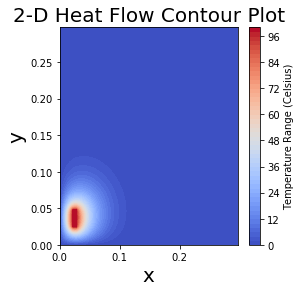

In [16]:
xgrid, ygrid, xlist, ylist = makegrid(Lx, Ly, Delta)
#v = linspace(0,10,10, endpoint=True)

fig, ax1 = plt.subplots(1, 1, figsize = plt.figaspect(1))
tempplot = contourf(xgrid, ygrid, Thistory1[4], 50, cmap = cm.coolwarm)


tempbar = colorbar(tempplot)
tempbar.set_label('Temperature Range (Celsius)')
clim(0,100)

ax1.set_xlabel('x', fontsize=20)
ax1.set_ylabel('y', fontsize=20)
ax1.set_title('2-D Heat Flow Contour Plot', fontsize=20)

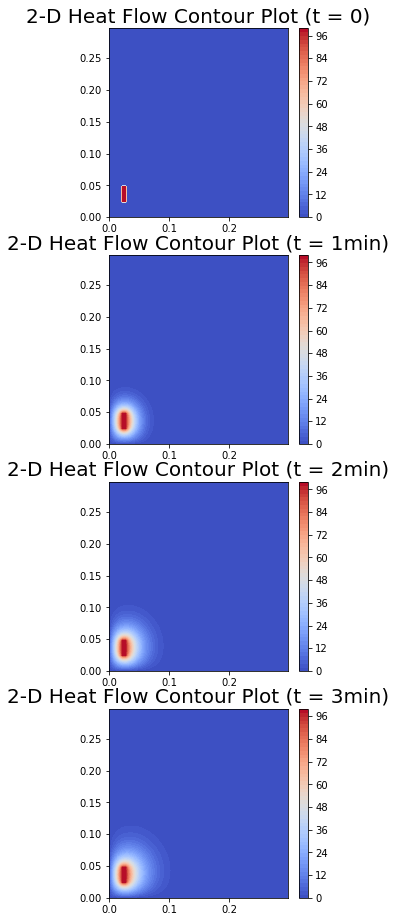

In [24]:
xgrid, ygrid, xlist, ylist = makegrid(Lx, Ly, Delta)
#v = linspace(0,10,10, endpoint=True)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = plt.figaspect(4))

plot1 = ax1.contourf(xgrid, ygrid, Thistory1[0], 50, cmap = cm.coolwarm)
plot2 = ax2.contourf(xgrid, ygrid, Thistory1[1], 50, cmap = cm.coolwarm)
plot3 = ax3.contourf(xgrid, ygrid, Thistory1[2], 50, cmap = cm.coolwarm)
plot4 = ax4.contourf(xgrid, ygrid, Thistory1[3], 50, cmap = cm.coolwarm)

#ax1.set_xlabel('x', fontsize=20)
#ax1.set_ylabel('y', fontsize=20)
ax1.set_title('2-D Heat Flow Contour Plot (t = 0)', fontsize=20)
plt.colorbar(plot1, ax=ax1)

#ax2.set_xlabel('x', fontsize=20)
#ax2.set_ylabel('y', fontsize=20)
ax2.set_title('2-D Heat Flow Contour Plot (t = 1min)', fontsize=20)
plt.colorbar(plot2, ax=ax2)

#ax3.set_xlabel('x', fontsize=20)
#ax3.set_ylabel('y', fontsize=20)
ax3.set_title('2-D Heat Flow Contour Plot (t = 2min)', fontsize=20)
plt.colorbar(plot3, ax=ax3)

#ax4.set_xlabel('x', fontsize=20)
#ax4.set_ylabel('y', fontsize=20)
ax4.set_title('2-D Heat Flow Contour Plot (t = 3min)', fontsize=20)
plt.colorbar(plot4, ax=ax4)

# Interpolation Code

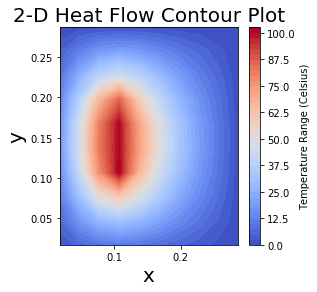

In [71]:
xsensors = [.017, .047, .077, .107, .137, .167, .197, .227, .257, .287]
ysensors = [.017, .047, .077, .107, .137, .167, .197, .227, .257, .287]
xsensorgrid, ysensorgrid = meshgrid(xsensors, ysensors)

xgrid, ygrid, xlist, ylist = makegrid(Lx, Ly, Delta)

Interp_Spline = RectBivariateSpline(xlist, ylist, Thistory1[3])
sensortemps = Interp_Spline(xsensors, ysensors)


fig, ax1 = plt.subplots(1, 1, figsize = plt.figaspect(1))
tempplot = contourf(xsensorgrid, ysensorgrid, sensortemps, 50, cmap = cm.coolwarm)

tempbar = colorbar(tempplot)
tempbar.set_label('Temperature Range (Celsius)')
clim(0,100)
ax1.set_xlabel('x', fontsize=20)
ax1.set_ylabel('y', fontsize=20)
ax1.set_title('2-D Heat Flow Contour Plot', fontsize=20)

In [263]:
Interp_Spline(.10,.15)

array([[ 53.85933859]])

In [264]:
sensortemps

array([[  2.30417604e+00,   6.16735788e+00,   9.19569131e+00,
          1.04417107e+01,   9.64738199e+00,   7.70545054e+00,
          5.54104046e+00,   3.55074669e+00,   1.78544361e+00,
          1.59655036e-01],
       [  6.52635027e+00,   1.77908471e+01,   2.72851429e+01,
          3.11044166e+01,   2.77738305e+01,   2.14310142e+01,
          1.51023580e+01,   9.58076659e+00,   4.79568511e+00,
          4.28223809e-01],
       [  1.08571159e+01,   3.07010142e+01,   5.12226538e+01,
          6.04866589e+01,   4.84218174e+01,   3.48170602e+01,
          2.37584981e+01,   1.48520447e+01,   7.38571962e+00,
          6.58148414e-01],
       [  1.44140923e+01,   4.19225565e+01,   7.72147232e+01,
          1.02232213e+02,   6.71003466e+01,   4.54084735e+01,
          3.02564408e+01,   1.86978391e+01,   9.24803598e+00,
          8.22667552e-01],
       [  1.60864255e+01,   4.66284009e+01,   8.23890832e+01,
          1.00640251e+02,   7.34379468e+01,   5.02399893e+01,
          3.33144716e+01

# Exporting the interpolation data and its corresponding time to a csv file


In [46]:
import csv

filename = input('Name of File? ') #needs to be csv, ie. filename.csv

count = 0

for item in Thistory1:
    csvdata =[]
    Interp_Spline = RectBivariateSpline(xlist, ylist, Thistory1[count])
    sensortemps = Interp_Spline(xsensors, ysensors)
    csvdata.append(tvect[count])
    csvdata.append(sensortemps)
    count += 1
    
    with open(filename, 'a') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(csvdata)


Name of File? SimulationTemps-0.csv


In [47]:
csvdata

[720.25, array([[  2.30456309e+00,   6.16852297e+00,   9.19795260e+00,
           1.04456224e+01,   9.65336231e+00,   7.71314483e+00,
           5.54920631e+00,   3.55769229e+00,   1.78959975e+00,
           1.60051718e-01],
        [  6.52720734e+00,   1.77933846e+01,   2.72900536e+01,
           3.11133824e+01,   2.77886332e+01,   2.14508777e+01,
           1.51237940e+01,   9.59911760e+00,   4.80669380e+00,
           4.29275303e-01],
        [  1.08580132e+01,   3.07034739e+01,   5.12268674e+01,
           6.04951558e+01,   4.84410915e+01,   3.48457115e+01,
           2.37903655e+01,   1.48796133e+01,   7.40232316e+00,
           6.59736105e-01],
        [  1.44147586e+01,   4.19240660e+01,   7.72158828e+01,
           1.02231206e+02,   6.71199248e+01,   4.54421311e+01,
           3.02950543e+01,   1.87315818e+01,   9.26843376e+00,
           8.24620156e-01],
        [  1.60869257e+01,   4.66293844e+01,   8.23895954e+01,
           1.00639630e+02,   7.34577569e+01,   5.02756659e+01

In [83]:
filename = input('Name of File? ') #needs to be csv, ie. filename.csv
file_object  = open(filename, 'w')

count = 0

for item in Thistory1:
    csvdata =[]
    templist = []
    Interp_Spline = RectBivariateSpline(xlist, ylist, Thistory1[count])
    sensortemps = Interp_Spline(xsensors, ysensors)
    #csvdata.append(tvect[count])
    #csvdata.append(sensortemps)
    time = str(tvect[count])
    file_object.write(time + '\n')
    
    for row in sensortemps:
        for num in row:
            temp = str(num)
            file_object.write(temp + ' ')
        
    count += 1
    file_object.write('\n')
    
    #file_object.write(time)
    #file_object.write(sensortemps)
    
file_object.close()

Name of File? SimulationTemps-0.csv


In [82]:
temp


'0.028364520482'